In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.optimize import minimize  # For optimization
from sklearn.model_selection import learning_curve

In [2]:
# Load the preprocessed datasets
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train_claim = pd.read_csv("y_train_claim.csv")
y_test_claim = pd.read_csv("y_test_claim.csv")
y_train_cost = pd.read_csv("y_train_cost.csv")
y_test_cost = pd.read_csv("y_test_cost.csv")

In [3]:
# Scale numerical features
numerical_features = X_train.select_dtypes(include=np.number).columns  # Scale only numeric
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### Linear Regression

In [4]:
# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train_claim)

LinearRegression()

In [5]:
# Make Predictions
y_pred = model.predict(X_test)

In [6]:
# Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test_claim, y_pred))
mae = mean_absolute_error(y_test_claim, y_pred)
r2 = r2_score(y_test_claim, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

Root Mean Squared Error (RMSE): 121236.97
Mean Absolute Error (MAE): 101410.66
R-squared (R^2): 0.24


#### Root Mean Squared Error (RMSE): 121236.97
An RMSE of 121236.97 means that, on average, the model's predictions are about 121236.97 minutes off from the actual claim times.  This is a very large error, suggesting that the model is not capturing the variability in the data well.

#### Mean Absolute Error (MAE): 101410.66
An MAE of 101410.66 indicates that, on average, the model's predictions are about 101410.66 minutes off.  Again, this is a substantial error.

#### R-squared (R^2): 0.24
An R-squared of 0.24 means that the model explains only 24% of the variance in time_to_claim.  This is a low R-squared, further indicating that the model is not a good fit for the data.

In [7]:
# Cross-Validation (using scaled data)
cv_scores = cross_val_score(model, X_train, y_train_claim, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -cv_scores

print("Cross-validation RMSE scores:", rmse_scores)
print(f"Mean CV RMSE: {rmse_scores.mean():.2f}")
print(f"Std CV RMSE: {rmse_scores.std():.2f}")

Cross-validation RMSE scores: [119375.78696539 121672.57618523 122307.44990876 120556.54956394
 120690.88862676]
Mean CV RMSE: 120920.65
Std CV RMSE: 1006.04


### Key Observations:
1. Consistently High RMSE Across Folds
- RMSE values (~120K) are very large, meaning the model struggles to make accurate predictions.
- This suggests that linear regression may not be the best fit for the data.

2. Low Variability (Std Dev = 1006.04)
- The standard deviation is small (1006.04), indicating that the model's performance is stable across different subsets of the data.
- This suggests that the issue is not due to data variance but rather model limitations.

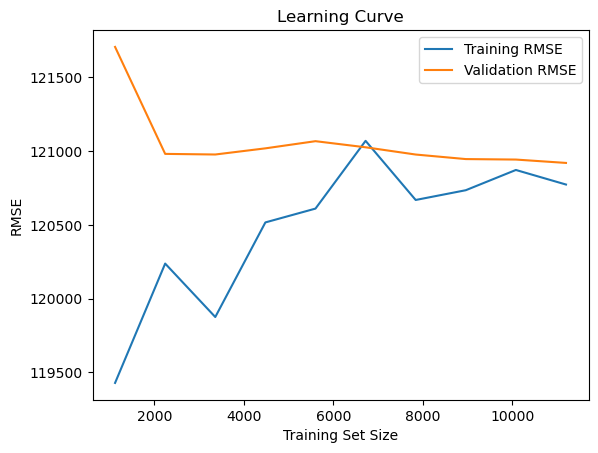

In [8]:
# Evaluate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train_claim, cv=5, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)  # 10% to 100% of data
)

train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_rmse, label='Training RMSE')
plt.plot(train_sizes, val_rmse, label='Validation RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.show()

### Key Observations:

#### High RMSE Across Training and Validation Sets (~120K)
- Both training and validation RMSE are very high, indicating poor predictive performance.

#### Small Generalization Gap
- The gap between training and validation RMSE is small, meaning low variance (not overfitting).
- However, both scores are consistently poor, suggesting high bias (underfitting).

#### Minimal Improvement with More Data
- The validation RMSE does not significantly decrease as training size increases.
- This suggests that adding more data alone won't improve performance—a better model or feature engineering is needed.

### XGBoost (Claim)

In [9]:
# Initialize and train the XGBoost Regressor
claim_model = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             n_estimators=200,  
                             learning_rate=0.1, 
                             max_depth=7,
                             colsample_bytree=1.0,
                             subsample=0.8)       

In [10]:
# Train on the full training data (after cross-validation)
claim_model.fit(X_train, y_train_claim)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
# Make predictions on the test set
y_pred_claim = claim_model.predict(X_test)

In [12]:
# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test_claim, y_pred_claim))
mae_xgb = mean_absolute_error(y_test_claim, y_pred_claim)
r2_xgb = r2_score(y_test_claim, y_pred_claim)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost R-squared: {r2_xgb:.2f}")

XGBoost RMSE: 82002.49
XGBoost MAE: 46724.60
XGBoost R-squared: 0.65


The R-squared score of 0.65 means the model explains 65% of the variance in claim times, which is a big improvement over the 0.24 from linear regression.
However, RMSE (82002.49) is still quite high, suggesting there may still be noisy or missing key features.

In [13]:
# Cross-validation
cv_scores = cross_val_score(claim_model, X_train, y_train_claim, cv=5, 
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
rmse_scores = -cv_scores  # Convert to positive RMSE

print(f"XGBoost CV RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

XGBoost CV RMSE: 82226.41 (+/- 1184.83)


In [14]:
# Feature Importance
importance = claim_model.feature_importances_
print("Feature Importance:")
for i, feature in enumerate(X_train.columns):
    print(f"{feature}: {importance[i]:.4f}")

Feature Importance:
cumulative_boost_amount_cents: 0.0507
total_predicted_duration_mins: 0.0228
total_predicted_distance_miles: 0.0404
is_same_day_ride: 0.0840
trip_starts_during_peak_hours: 0.0270
hour_of_day: 0.0266
day_of_week: 0.0524
month: 0.2288
commute_minutes: 0.0239
commute_distance: 0.0265
seq_boost_count: 0.2010
manual_boost: 0.1302
boost_ind: 0.0000
total_predicted_distance_miles_for_fare: 0.0319
dollars_paid_to_driver: 0.0539


#### Top Predictors:
- month (0.2288) → Strongest predictor, reinforcing seasonality effects in ride claims.
- seq_boost_count (0.2010) → Number of consecutive boosts significantly impacts claim times.
- manual_boost (0.1302) → A feature indicating that manually applied boosts play a big role.

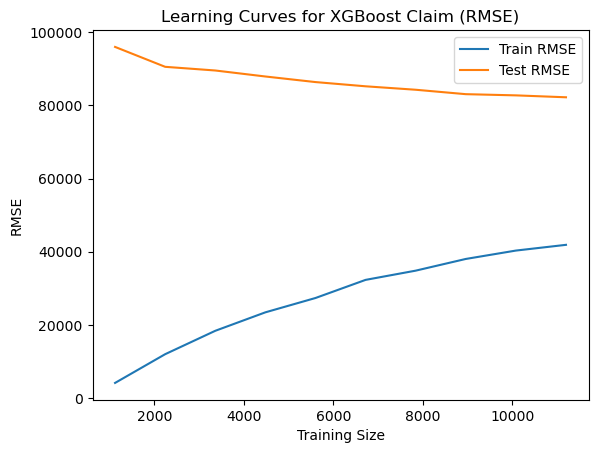

In [15]:
# Creates 10 evenly spaced sizes from 10% to 100% of the data
train_sizes = np.linspace(0.1, 1.0, 10) 

# For RMSE:
train_sizes, train_scores_rmse, test_scores_rmse = learning_curve(
    claim_model, X_train, y_train_claim, cv=5, train_sizes=train_sizes,
    scoring='neg_mean_squared_error'
)
train_scores_rmse = np.sqrt(-train_scores_rmse)  # Get RMSE
test_scores_rmse = np.sqrt(-test_scores_rmse)  # Get RMSE

# Plotting with RMSE:
plt.plot(train_sizes, np.mean(train_scores_rmse, axis=1), label="Train RMSE")
plt.plot(train_sizes, np.mean(test_scores_rmse, axis=1), label="Test RMSE")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()
plt.title("Learning Curves for XGBoost Claim (RMSE)")
plt.show()

#### Underfitting (Initially): 
At smaller training sizes, the test RMSE is much higher than the training RMSE, suggesting the model was underfitting. It didn't have enough data to learn complex patterns and generalize well.
#### Benefit of More Data (Up to a Point): 
The sharp decrease in test RMSE with increasing training size shows that providing more data is highly beneficial. The model learns better and generalizes more effectively.
#### Diminishing Returns: 
As the training size increases further, the rate of improvement in test RMSE diminishes. This suggests that simply adding more data might not yield substantial gains beyond a certain point.
#### Potential for Improvement: 
The test RMSE is still slightly decreasing at the largest training size. This indicates that there might still be some benefit in acquiring more data, but the gains might be marginal.

In [16]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],  # Add subsample for regularization
    'colsample_bytree': [0.8, 1.0] # Add colsample_bytree for regularization
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42),  # Initialize within GridSearchCV
                           param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train_claim)

best_xgb_model = grid_search.best_estimator_
print("Best XGBoost Hyperparameters:", grid_search.best_params_)

y_pred_best_xgb = best_xgb_model.predict(X_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test_claim, y_pred_best_xgb))
print(f"Best XGBoost RMSE: {rmse_best_xgb:.2f}")

Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost RMSE: 82002.49


### XGBoost (Cost)

In [17]:
# XGBoost Model 2: Boost Cost Prediction
cost_model = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             n_estimators=200,  
                             learning_rate=0.01, 
                             max_depth=7,
                             colsample_bytree=0.8,
                             subsample=0.8) 

In [18]:
cost_model.fit(X_train, y_train_cost)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
# Make predictions on the test set
y_pred_cost = cost_model.predict(X_test)

In [20]:
# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test_cost, y_pred_cost))
mae_xgb = mean_absolute_error(y_test_cost, y_pred_cost)
r2_xgb = r2_score(y_test_cost, y_pred_cost)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost R-squared: {r2_xgb:.2f}")

XGBoost RMSE: 74.06
XGBoost MAE: 26.12
XGBoost R-squared: 0.94


#### RMSE (Root Mean Squared Error): 74.06
An RMSE of 74.06 suggests that the model is performing well. This means, on average, the model's predictions deviate from the actual values by approximately 74.06 units of the target variable (e.g., boost cost per mile in cents).

#### MAE (Mean Absolute Error): 26.12
With an MAE of 26.12, the model is very accurate in predicting the boost cost, with an average absolute error of just 26.12 units.

#### R-squared: 0.94
An R-squared of 0.94 means 94% of the variability in boost costs can be explained by the model's features. This indicates that the model is able to make highly accurate predictions.

In [21]:
# Cross-validation
cv_scores = cross_val_score(cost_model, X_train, y_train_cost, cv=5, 
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
rmse_scores = -cv_scores  # Convert to positive RMSE

print(f"XGBoost CV RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

XGBoost CV RMSE: 273.45 (+/- 271.91)


In [22]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],  # Add subsample for regularization
    'colsample_bytree': [0.8, 1.0] # Add colsample_bytree for regularization
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42),  # Initialize within GridSearchCV
                           param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train_cost)

best_xgb_model = grid_search.best_estimator_
print("Best XGBoost Hyperparameters:", grid_search.best_params_)

y_pred_best_xgb = best_xgb_model.predict(X_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test_cost, y_pred_best_xgb))
print(f"Best XGBoost RMSE: {rmse_best_xgb:.2f}")

Best XGBoost Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost RMSE: 74.06


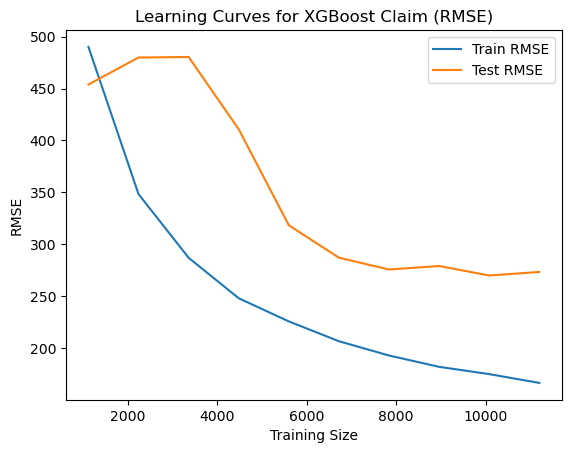

In [23]:
# Creates 10 evenly spaced sizes from 10% to 100% of the data
train_sizes = np.linspace(0.1, 1.0, 10) 

# For RMSE:
train_sizes, train_scores_rmse, test_scores_rmse = learning_curve(
    cost_model, X_train, y_train_cost, cv=5, train_sizes=train_sizes,
    scoring='neg_mean_squared_error'
)
train_scores_rmse = np.sqrt(-train_scores_rmse)  # Get RMSE
test_scores_rmse = np.sqrt(-test_scores_rmse)  # Get RMSE

# Plotting with RMSE:
plt.plot(train_sizes, np.mean(train_scores_rmse, axis=1), label="Train RMSE")
plt.plot(train_sizes, np.mean(test_scores_rmse, axis=1), label="Test RMSE")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()
plt.title("Learning Curves for XGBoost Claim (RMSE)")
plt.show()

#### Initial Underfitting: 
The significant gap between train and test RMSE at smaller training sizes indicates initial underfitting. The model is too simple to capture the underlying patterns.
#### Good Learning: 
The sharp decrease in test RMSE shows good learning as the training size increases.
#### Potential Overfitting (Towards the End): 
The slight uptick in the test RMSE at the largest training sizes could suggest the beginning of overfitting. The model might be starting to memorize the training data too well, at the expense of generalization.
#### Room for Improvement: 
The fact that the test RMSE is still relatively high suggests there's room for improvement.

### Bi-objective Optimization 
Find the best balance between boost amount and predicted distance to minimize both time to claim and cost, using a weighted approach to prioritize time to claim. It uses a combination of trained models (claim_model, cost_model) and a numerical optimization algorithm (minimize).

In [24]:
# Get the mean values of all features from X_train (except boost_amount & distance_miles)
feature_means = X_train.mean()

# Ensure min/max values are scalars
y_train_claim_min = y_train_claim.min().item()
y_train_claim_max = y_train_claim.max().item()
y_train_cost_min = y_train_cost.min().item()
y_train_cost_max = y_train_cost.max().item()

In [25]:
# OpenAI GPT-4o
# AI Prompt: I have two XGBoost models, one predicting time to claim and the other predicting cost. 
# Write a Python function to find the optimal boost amount and distance to minimize a weighted sum of the predictions.

# Define the objective function to minimize both time_to_claim and boost_per_mile
def objective(params):
    boost_amount, distance_miles = params

    # Ensure values stay within bounds
    boost_amount = np.clip(boost_amount, 0, 500)  # 0 - 500 cents
    distance_miles = np.clip(distance_miles, 1, 50)  # 1 - 50 miles

    # Create a full feature vector for prediction (use mean values for all features except 2 dynamic ones)
    feature_vector = feature_means.copy()
    feature_vector["cumulative_boost_amount_cents"] = boost_amount
    feature_vector["total_predicted_distance_miles"] = distance_miles

    # Convert to DataFrame and ensure it has the correct shape
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Get predictions and convert them into scalars
    time_to_claim_pred = float(claim_model.predict(feature_vector).flatten()[0])  
    cost_pred = float(cost_model.predict(feature_vector).flatten()[0])  

    # Normalize objectives (to bring them to a similar scale) using precomputed min/max scalars
    time_to_claim_norm = (time_to_claim_pred - y_train_claim_min) / (y_train_claim_max - y_train_claim_min)
    cost_norm = (cost_pred - y_train_cost_min) / (y_train_cost_max - y_train_cost_min)

    # Assign weights to both objectives
    weight_claim = 0.7  # Prioritize reducing time_to_claim
    weight_cost = 0.3  # Less priority to cost
    
    # Weighted sum of both normalized objectives (ensuring scalar return)
    return float(weight_claim * time_to_claim_norm + weight_cost * cost_norm)

In [26]:
# Optimization: Minimize the weighted sum of time_to_claim and boost_per_mile
initial_guess = [100, 10]  # Initial guess for boost_amount and distance_miles
bounds = [(0, 500), (1, 50)]  # Constraints (boost amount: 0-500 cents, distance: 1-50 miles)

# Perform optimization
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

# Extract the optimal values
optimal_boost_amount, optimal_distance = result.x

print(f"Optimal Boost Amount: {optimal_boost_amount:.2f} cents")
print(f"Optimal Distance: {optimal_distance:.2f} miles")

# Predict the optimized values
feature_vector = feature_means.copy()
feature_vector["cumulative_boost_amount_cents"] = optimal_boost_amount
feature_vector["total_predicted_distance_miles"] = optimal_distance
feature_vector = np.array(feature_vector).reshape(1, -1)

optimized_time_to_claim = float(claim_model.predict(feature_vector).flatten()[0])
optimized_cost = float(cost_model.predict(feature_vector).flatten()[0])

print(f"Optimized Time to Claim: {optimized_time_to_claim:.2f} minutes")
print(f"Optimized Boost Cost per Mile: {optimized_cost:.2f}")

Optimal Boost Amount: 100.00 cents
Optimal Distance: 10.00 miles
Optimized Time to Claim: 6704.89 minutes
Optimized Boost Cost per Mile: 217.75


#### Predicted Values: 
All the values (time to claim and cost) are predictions from models (claim_model and cost_model). They are not the actual observed values for a real trip.

#### Optimization Goal: 
The optimization is aimed to find the boost_amount and distance_miles that minimize a weighted combination of time_to_claim and cost. The weights chosen (0.7 for time to claim and 0.3 for cost) reflect the relative importance placed on each objective.

#### Trade-off: 
The optimal solution represents a trade-off between the two objectives. Likely reduced the time to claim, but there's a cost associated with the boost.

### Next Steps:

#### Evaluate the Results: 
It's crucial to evaluate how well this optimized solution performs in the real world. Compare the predicted time_to_claim and cost to the actual values for trips with similar characteristics.

#### Sensitivity Analysis: 
Consider performing a sensitivity analysis to see how the results change if the weights assigned vary to the objectives.

#### Refine Models: 
Need to refine claim_model and cost_model or consider additional features that might be influencing the outcomes.